## Part 0: Data visualization
### Understand the dataset by plotting

This is a low-dimensinoal digit recognition dataset. You can show the data as follow. 

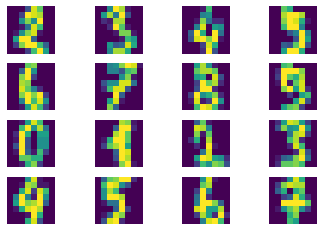

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


digits = load_digits()
X, y = digits.data, digits.target

for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(X[i+1].reshape((8,8)))
    plt.axis('off')
plt.show()

### Training and Testing Split

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Part 1: Random Forest

Please apply the Random Forest Method to this dataset. 

1. Please use [`sckit-optimize`](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html) to optimize the following tuning parmaeters `n_estimators`, `max_depth`, `max_features`, etc.
2. Please find the `feature_importance` coefficient and try to visualize the feature importance matrix in terms of images (by reshaping them into 8x8 matrix and visualize). 


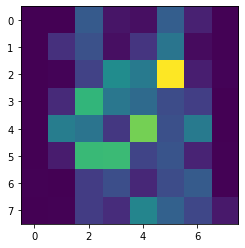

In [3]:
from sklearn.ensemble import RandomForestClassifier
#-----------
clf = RandomForestClassifier(max_depth=32, n_estimators=8, max_features=32)
clf.fit(X_train,y_train)

importances = clf.feature_importances_
plt.imshow(importances.reshape((8,8)))

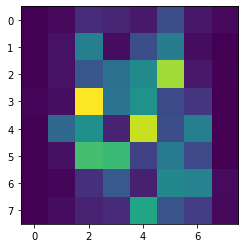

In [4]:
clf = RandomForestClassifier(max_depth=40, n_estimators=5, max_features=35)
clf.fit(X_train,y_train)

importances = clf.feature_importances_
plt.imshow(importances.reshape((8,8)))

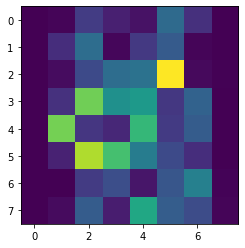

In [15]:
clf = RandomForestClassifier(max_depth=50, n_estimators=6, max_features=30)
clf.fit(X_train,y_train)

importances = clf.feature_importances_
plt.imshow(importances.reshape((8,8)))

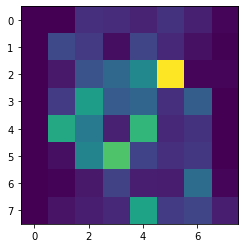

In [37]:
clf = RandomForestClassifier(max_depth=30, n_estimators=4, max_features=20)
clf.fit(X_train,y_train)

importances = clf.feature_importances_
plt.imshow(importances.reshape((8,8)))

## Part 2:  Shap Value Interpretation 

In this problem, we will use the `shap` package to explain the random forest module and display it in the image format. You can follow the following steps for the analysis. 

1. please use the `TreeExplainer` module from the `shap` library on the random forest models
2. Get the `shap_values` on the first 10 testing dataset. The `shap_values` should be a list of 10, each corresponding to one class (0-9) and each element from the list should be a 10x64 numpy array.
3. Please use the `image_plot` module from `shap` value to visualize the images. Please see the [tutorial](https://shap.readthedocs.io/en/stable/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html) for shap value image plot. Overall, you need to input two array, `shap_values` and `pixel_values`. Here, `shap_values` is a list of arrays of SHAP values. Each array has the shap (# samples x width x height x channels). Here, it should be reshaped to (10 x 8 x 8 x 1) and the length of the list is 10. The `pixel_values` should be reshaped to 10 x 8 x 8 x 1. 


In [40]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import shap

In [41]:
batch_size = 150
num_epochs = 2
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.286122
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.123918
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.201572
Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.957832

Test set: Average loss: 0.0042, Accuracy: 8892/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.564793
Train Epoch: 2 [15000/60000 (25%)]	Loss: 0.566584
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.615724
Train Epoch: 2 [45000/60000 (75%)]	Loss: 0.589295

Test set: Average loss: 0.0025, Accuracy: 9285/10000 (93%)



In [42]:
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:103]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


In [43]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

### Plot the feature attributions

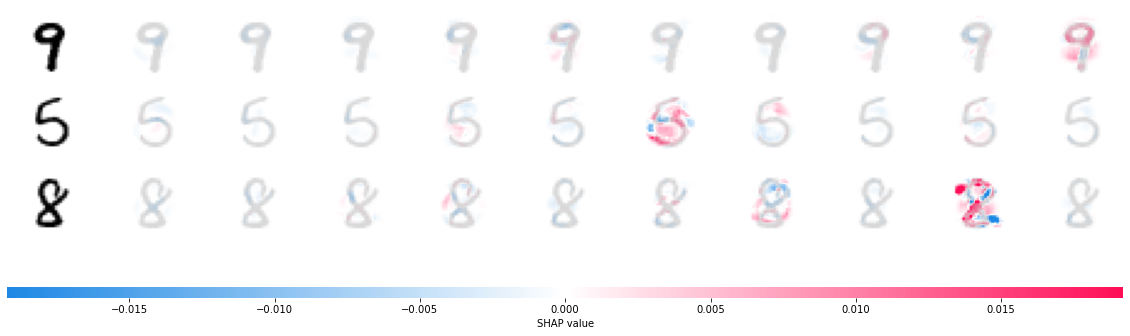

In [44]:
shap.image_plot(shap_numpy, -test_numpy)

## Part 3: CNN
Please design a convolutiona neural network architecture to map the $8\times8$ matrix into the classes `0-9`. You can feel free to use the deep learning libraries such as `Pytorch` and `tensorflow`. 

In [20]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# Hyper Parameters
num_epochs = 6
batch_size = 150
learning_rate = 0.001

In [21]:
train_dataset = dsets.MNIST(root='./data/',
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data/',
                           train=False, 
                           transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)



In [22]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
        
cnn = CNN()
iscuda = False
if iscuda:
    cnn.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

### Train the Model

In [23]:
num_epochs = 3
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        if iscuda:
            images = images.cuda()
            labels = labels.cuda()
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        accuracy=((predicted.cpu() == labels).sum()+0.)/labels.size(0)
        
        if (i+1) % 100 == 0:
            
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f Train Acc: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data,accuracy.data))


Epoch [1/3], Iter [100/400] Loss: 0.1567 Train Acc: 0.9467
Epoch [1/3], Iter [200/400] Loss: 0.0800 Train Acc: 0.9933
Epoch [1/3], Iter [300/400] Loss: 0.0856 Train Acc: 0.9533
Epoch [1/3], Iter [400/400] Loss: 0.0302 Train Acc: 0.9933
Epoch [2/3], Iter [100/400] Loss: 0.0621 Train Acc: 0.9800
Epoch [2/3], Iter [200/400] Loss: 0.0390 Train Acc: 0.9933
Epoch [2/3], Iter [300/400] Loss: 0.0762 Train Acc: 0.9733
Epoch [2/3], Iter [400/400] Loss: 0.0431 Train Acc: 0.9800
Epoch [3/3], Iter [100/400] Loss: 0.0153 Train Acc: 1.0000
Epoch [3/3], Iter [200/400] Loss: 0.0701 Train Acc: 0.9733
Epoch [3/3], Iter [300/400] Loss: 0.0539 Train Acc: 0.9933
Epoch [3/3], Iter [400/400] Loss: 0.0299 Train Acc: 0.9867


### Test the Model

In [24]:
cnn.eval() 
correct = 0
total = 0
for images, labels in test_loader:
    if iscuda:
        images = images.cuda()
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()

print('Test Accuracy of the model on the 10000 test images: %d %%' % (100 * correct / total))
torch.save(cnn.state_dict(), 'cnn.pkl')

Test Accuracy of the model on the 10000 test images: 98 %
